Vamos a verificar el correcto funcionamiento de varias de las funciones de similaridad y de normalizacion.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def generate_ratings_matrix(data_rows: np.ndarray):
    r = np.zeros((943, 1682))
    r[:] = np.nan
    for i in data_rows:
        r[i[0] - 1][i[1] - 1] = i[2]
    return r

In [2]:
r = generate_ratings_matrix(pd.read_csv("../data/train.csv").values)

In [3]:
r

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

# Similaridad: Correlación de Pearson

Sólo vamos a usar esta basada en el artículo de investigación de Herlocker, Konstan y Ried, donde se ha visto que para el caso concreto de Movielens100K la correlación de Pearson es la que mejores resultados da.

In [50]:
def pearson_correlation(u: np.ndarray, v: np.ndarray):
    """
    Computes the pearson correlation between two vectors
    Args:
        u: First vector
        v: Second vector

    Returns:
        The pearson correlation value
    """

    u_mean = np.nanmean(u)
    v_mean = np.nanmean(v)

    mean_deviation = (u - u_mean) * (v - v_mean)
    num = np.nansum(mean_deviation)

    # We can get the common elements from mean_deviation
    common_indices = np.argwhere(~ np.isnan(mean_deviation))
    u_common = u[common_indices]
    v_common = v[common_indices]

    den = np.sqrt(np.sum(np.square(u_common - u_mean)) * np.sum(np.square(v_common - v_mean)))
    return num / den

def compute_sim(data):
    sim_matrix = np.zeros((943, 943))

    for i, u in tqdm(enumerate(data)):
        for j, v in enumerate(data):
            sim_matrix[i][j] = pearson_correlation(u, v)
    return sim_matrix

In [51]:
sim_matrix = compute_sim(r)

1it [00:00,  5.51it/s]/var/folders/83/9r8j1fgd24565dkqk6cy93480000gp/T/ipykernel_31764/563217533.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return num / den
943it [02:54,  5.41it/s]


In [52]:
sim_matrix

array([[ 1.        ,  0.21493829,  0.13931314, ...,  0.22516616,
        -0.15267653,  0.08732096],
       [ 0.21493829,  1.        , -0.21903385, ..., -0.29904328,
         0.203545  ,  0.14623625],
       [ 0.13931314, -0.21903385,  1.        , ...,  0.83481571,
         0.31565668,  0.12403473],
       ...,
       [ 0.22516616, -0.29904328,  0.83481571, ...,  1.        ,
        -0.48163175,  0.07110123],
       [-0.15267653,  0.203545  ,  0.31565668, ..., -0.48163175,
         1.        ,  0.38047957],
       [ 0.08732096,  0.14623625,  0.12403473, ...,  0.07110123,
         0.38047957,  1.        ]])

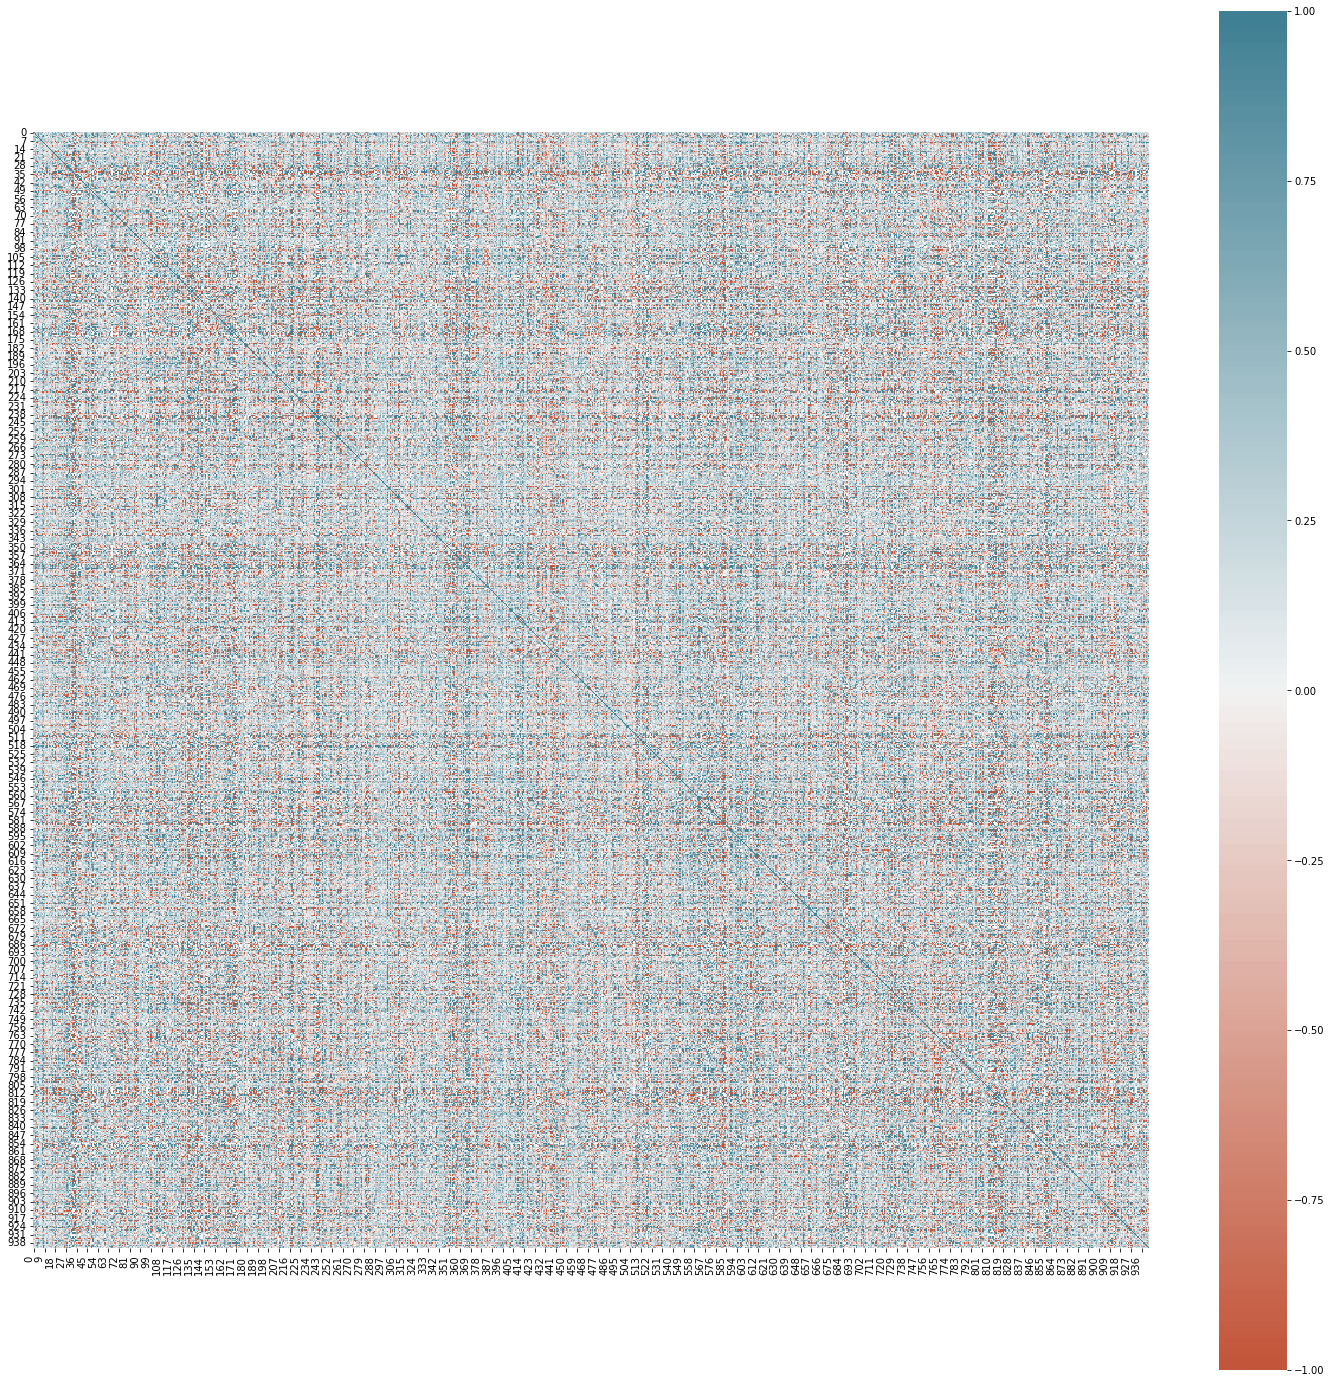

In [62]:
plt.figure(figsize=(25, 25))
ax = sns.heatmap(
    sim_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# Normalización (Mean Centering)

Generamos un método para obtener información relevante sobre los procesos de normalización.

In [11]:
def get_user_info(index):
    print("Original ratings: ", r[index][~ np.isnan(r[index])][0:20])
    print("Normalized ratings: ", r_centered[index][~ np.isnan(r[index])][0:20])
    print("User mean: ", user_means[index][index])

In [5]:
class MeanCentering:
    def __init__(self, user: bool = True):
        self.user = user
        self.means = []

    def transform(self, r: np.ndarray):
        n_u, n_i = r.shape
        if self.user:
            self.means = np.hstack([np.reshape(np.nanmean(r, axis=1), (-1, 1))]*n_i)
        else:
            self.means = np.vstack([np.reshape(np.nanmean(r, axis=0), (1, -1))]*n_u)
        return r - self.means

    def reverse_transform(self, r: np.ndarray):
        return r + self.means

In [6]:
mean_centering = MeanCentering()

In [7]:
r_centered = mean_centering.transform(r)

In [8]:
r_reversed = mean_centering.reverse_transform(r_centered)

In [9]:
r_reversed

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [10]:
r

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [12]:
user_means = mean_centering.means

### User 0

Tomamos los 20 primeros ratings que estén informados. Y los comparamos con los ratings del usuario tras la normalización. Vemos que el usuario puntúa de media un 3.62. Esto explica que un 3, para este usuario, sea una puntuación negativa. Para otro usuario más exigente podría ser positiva no obstante.

In [13]:
get_user_info(0)

Original ratings:  [5. 3. 4. 3. 3. 5. 4. 1. 5. 3. 2. 5. 5. 5. 5. 5. 3. 4. 5. 4.]
Normalized ratings:  [ 1.37848606 -0.62151394  0.37848606 -0.62151394 -0.62151394  1.37848606
  0.37848606 -2.62151394  1.37848606 -0.62151394 -1.62151394  1.37848606
  1.37848606  1.37848606  1.37848606  1.37848606 -0.62151394  0.37848606
  1.37848606  0.37848606]
User mean:  3.6215139442231075


### User 180

El usuario 180 es el más exigente de todo el conjunto. Como podemos observar, su puntuaciómn media es de 1.50. De ahí que un 5 para este usuario deba entenderse con una preferencia mucho mayor que en el caso anterior.

In [14]:
get_user_info(180)

Original ratings:  [3. 2. 1. 4. 4. 2. 2. 3. 1. 1. 1. 1. 1. 1. 5. 1. 3. 1. 1. 1.]
Normalized ratings:  [ 1.49627792  0.49627792 -0.50372208  2.49627792  2.49627792  0.49627792
  0.49627792  1.49627792 -0.50372208 -0.50372208 -0.50372208 -0.50372208
 -0.50372208 -0.50372208  3.49627792 -0.50372208  1.49627792 -0.50372208
 -0.50372208 -0.50372208]
User mean:  1.5037220843672456


### User 800

El usuario 800, por ejemplo, puntúa muy positivamente casi todo. De hecho, su media es de un 4.08. De ahí que hasta una puntuación de 4 se estime como negativa en este caso.

In [15]:
get_user_info(800)

Original ratings:  [3. 3. 5. 5. 5. 5. 2. 5. 5. 4. 4. 5. 4. 5. 5. 5. 4. 4. 3. 4.]
Normalized ratings:  [-1.08 -1.08  0.92  0.92  0.92  0.92 -2.08  0.92  0.92 -0.08 -0.08  0.92
 -0.08  0.92  0.92  0.92 -0.08 -0.08 -1.08 -0.08]
User mean:  4.08


# Normalización (Z Score)

In [16]:
class ZScoreNormalization:
    def __init__(self, user: bool = True):
        self.user = user
        self.means = []
        self.stds = []

    def transform(self, r: np.ndarray):
        n_u, n_i = r.shape
        if self.user:
            self.means = np.hstack([np.reshape(np.nanmean(r, axis=1), (-1, 1))] * n_i)
            self.stds = np.hstack([np.reshape(np.nanstd(r, axis=1), (-1, 1))] * n_i)
        else:
            self.means = np.vstack([np.reshape(np.nanmean(r, axis=0), (1, -1))] * n_u)
            self.stds = np.vstack([np.reshape(np.nanstd(r, axis=0), (1, -1))] * n_u)

        return (r - self.means) / self.stds

    def reverse_transform(self, r: np.ndarray):
        # We use hadamard product
        return np.multiply(self.stds, r) + self.means

In [17]:
z_score_normalization = ZScoreNormalization()

In [19]:
r_centered = z_score_normalization.transform(r)

In [20]:
r_reversed = z_score_normalization.reverse_transform(r_mean_centered)

In [21]:
r_reversed

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [22]:
get_user_info(0)

Original ratings:  [5. 3. 4. 3. 3. 5. 4. 1. 5. 3. 2. 5. 5. 5. 5. 5. 3. 4. 5. 4.]
Normalized ratings:  [ 1.11297179 -0.50180231  0.30558474 -0.50180231 -0.50180231  1.11297179
  0.30558474 -2.11657641  1.11297179 -0.50180231 -1.30918936  1.11297179
  1.11297179  1.11297179  1.11297179  1.11297179 -0.50180231  0.30558474
  1.11297179  0.30558474]
User mean:  3.6215139442231075


In [23]:
get_user_info(180)

Original ratings:  [3. 2. 1. 4. 4. 2. 2. 3. 1. 1. 1. 1. 1. 1. 5. 1. 3. 1. 1. 1.]
Normalized ratings:  [ 1.743707    0.57834395 -0.58701911  2.90907005  2.90907005  0.57834395
  0.57834395  1.743707   -0.58701911 -0.58701911 -0.58701911 -0.58701911
 -0.58701911 -0.58701911  4.0744331  -0.58701911  1.743707   -0.58701911
 -0.58701911 -0.58701911]
User mean:  1.5037220843672456


In [24]:
get_user_info(800)

Original ratings:  [3. 3. 5. 5. 5. 5. 2. 5. 5. 4. 4. 5. 4. 5. 5. 5. 4. 4. 3. 4.]
Normalized ratings:  [-0.95698963 -0.95698963  0.81521339  0.81521339  0.81521339  0.81521339
 -1.84309113  0.81521339  0.81521339 -0.07088812 -0.07088812  0.81521339
 -0.07088812  0.81521339  0.81521339  0.81521339 -0.07088812 -0.07088812
 -0.95698963 -0.07088812]
User mean:  4.08
